# Gaussian Process Regression

In [38]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
from matplotlib import pyplot as plt


# suppress sklearn warnings
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, ExpSineSquared
from KRR_reproduce import *

## Parameters

In [39]:
kernel_choice = 'rbf'  # specify either c_rbf, rbf, matern or expsinesquared
m = 7  # number of training points

## Setup

In [40]:
ev2kcal = 1 / 0.043  # conversion factor
sim_no = 150  # total number of data points
np.random.seed(1)

# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'


## Load data

In [41]:
ens = []
seps = []

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')

    # format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']

    ens.append(en)
    seps.append(sep)


## Set up training and test data

In [42]:
data = seps
labels = ens

train_indices = [int(n) for n in np.round(np.linspace(0, 149, m))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != m:
    print("Size of training set doesn't match the m specified")

x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test = np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_train = x_train.reshape(-1, 1)
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_test_list = [data[n] for n in test_indices]
x_train_list = [data[n] for n in train_indices]


## Set kernel and print properties

In [43]:
kernel_dict = {
    'c_rbf': C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)),
    'rbf': RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2)),
    'matern': Matern(length_scale=10, length_scale_bounds=(1e-2, 1e2),
                     nu=10),
    'expsinesquared': ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                     length_scale_bounds=(1e-2, 1e2),
                                     periodicity_bounds=(1e-2, 1e2))}

kernel = kernel_dict[kernel_choice]

print("\nKernel: {}".format(kernel))
print("Hyperparameters: \n")

for hyperparameter in kernel.hyperparameters: print(hyperparameter)
print("Parameters:\n")

params = kernel.get_params()
for key in sorted(params): print("%s : %s" % (key, params[key]))


Kernel: RBF(length_scale=10)
Hyperparameters: 

Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  1.00000000e-02,   1.00000000e+02]]), n_elements=1, fixed=False)
Parameters:

length_scale : 10
length_scale_bounds : (0.01, 100.0)


## Build GP and fit

In [44]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)

print("\nFitting GP...")
gp.fit(x_train, y_train)


Fitting GP...


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=10), n_restarts_optimizer=20,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

## Inference

In [45]:
y_pred_test = gp.predict(np.atleast_2d(x_test_list).T)
y_pred_train = gp.predict(np.atleast_2d(x_train_list).T)
y_pred_all, sigma = gp.predict(np.atleast_2d(seps).T, return_std=True)

## Print Results

In [46]:
print("\n==========================================================================================")
print("MAE on training data in [kcal/mol]: \t{}".format(mean_absolute_error(y_train, y_pred_train) * ev2kcal))
print("MAE on test data in [kcal/mol]: \t{}".format(mean_absolute_error(y_test, y_pred_test) * ev2kcal))



MAE on training data in [kcal/mol]: 	5.2055871610326094e-09
MAE on test data in [kcal/mol]: 	1.3758100525847647


## Plot w/ confidence intervals

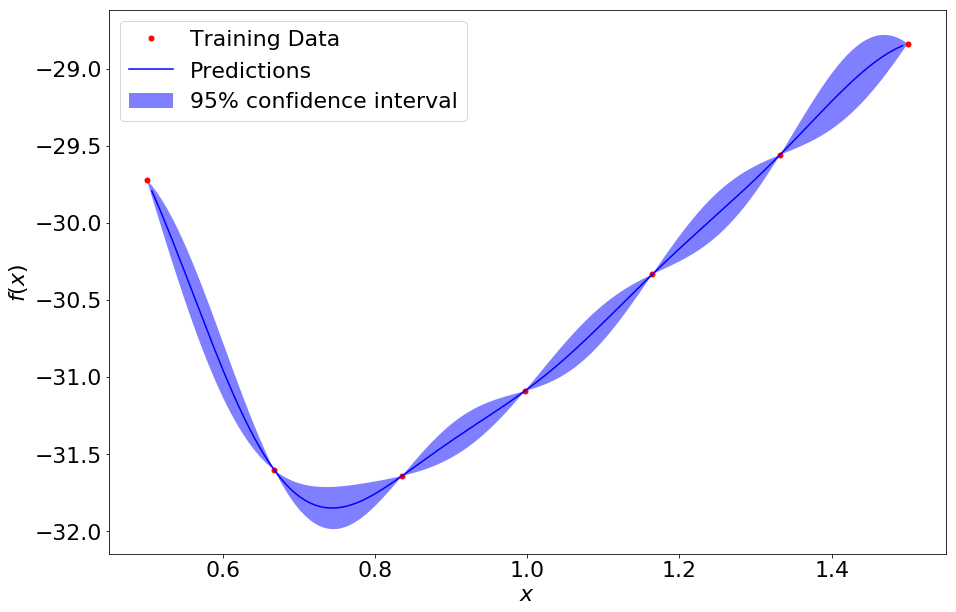

In [47]:
fig = plt.figure(figsize = (15, 10))
plt.plot(x_train, y_train, 'r.', markersize=10, label=u'Training Data')
plt.plot(x_test, y_pred_test, 'b-', label=u'Predictions')
plt.fill(np.concatenate([seps, seps[::-1]]),
         np.concatenate([y_pred_all - 1.9600 * sigma,
                         (y_pred_all + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.rcParams.update({'font.size': 22})
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')

plt.show()